In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
% matplotlib inline


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report, confusion_matrix)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

UsageError: Line magic function `%` not found.


Import the data

In [3]:
data = pd.read_csv('customers_data.csv')

In [4]:
data.head()

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,male,no,31.0,35.0,False
1,1,65.16,male,yes,23.0,61.0,False
2,2,40.60,female,no,36.0,49.0,False
3,3,38.01,male,yes,47.0,57.0,False
4,4,22.32,female,yes,5.0,39.0,False


In [5]:
data['loyalty'].value_counts() # data imbalance

False    100000
True      20000
Name: loyalty, dtype: int64

Let us check the data types

In [6]:
data.dtypes

Unnamed: 0                 int64
purch_amt                float64
gender                    object
card_on_file              object
age                      float64
days_since_last_purch    float64
loyalty                     bool
dtype: object

Let us change the variables 'gender' and 'card_on_file' to binary to fit into model

In [7]:
data['gender'] = data['gender'].map({'male': 1, 'female': 0})


In [8]:
data['card_on_file']= data['card_on_file'].map({'yes':1, 'no':0})

Let us see if there are any missing values

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 7 columns):
Unnamed: 0               120000 non-null int64
purch_amt                120000 non-null float64
gender                   120000 non-null int64
card_on_file             120000 non-null int64
age                      120000 non-null float64
days_since_last_purch    120000 non-null float64
loyalty                  120000 non-null bool
dtypes: bool(1), float64(3), int64(3)
memory usage: 5.6 MB


In [10]:
data.head()

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,1,0,31.0,35.0,False
1,1,65.16,1,1,23.0,61.0,False
2,2,40.60,0,0,36.0,49.0,False
3,3,38.01,1,1,47.0,57.0,False
4,4,22.32,0,1,5.0,39.0,False


There are no missing values in the data

In [21]:
#Feature engineering 
features =  pd.get_dummies(data[['purch_amt', 'gender', 'card_on_file', 'age', 'days_since_last_purch']])
target = data['loyalty']

In [24]:
#Split the data to train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(90000, 5)
(30000, 5)
(90000,)
(30000,)


Let us oversample the minority class (loyalty= 'True') as we are interested to know what factors contrbute to join the loyalty program

In [25]:
from imblearn.over_sampling import SMOTE
#Let us upsample the dataset
oversampler= SMOTE(random_state=0)
smote_X_train, smote_y_train = oversampler.fit_sample(X_train, y_train)

In [26]:
print(smote_X_train.shape), print(smote_y_train.shape)
print(X_test.shape), print(y_test.shape)

(149952, 5)
(149952,)
(30000, 5)
(30000,)


(None, None)

In [27]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
smote_X_train = sc.fit_transform(smote_X_train)
X_test = sc.transform(X_test)

Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report, confusion_matrix)

In [31]:
seed = 0   # We set our random seed to zero for reproducibility
# Random Forest parameters
rf_params = {
    'n_estimators': 1000,
    'max_features': 0.3,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

#Fitting the model 
rfm = RandomForestClassifier(** rf_params)
rfm.fit(smote_X_train, smote_y_train)
rfm_predictions = rfm.predict(X_test)
print('Accuracy Score for Random Forest Model:', rfm.score(X_test, y_test))
print(classification_report(y_test, rfm_predictions)) 
Confusion_matrix = confusion_matrix(y_test, rfm_predictions)
print(Confusion_matrix)

Accuracy Score for Random Forest Model: 0.7812666666666667
              precision    recall  f1-score   support

       False       0.95      0.78      0.86     25024
        True       0.42      0.80      0.55      4976

    accuracy                           0.78     30000
   macro avg       0.68      0.79      0.70     30000
weighted avg       0.86      0.78      0.80     30000

[[19466  5558]
 [ 1004  3972]]


Feature ranking via the Random Forest

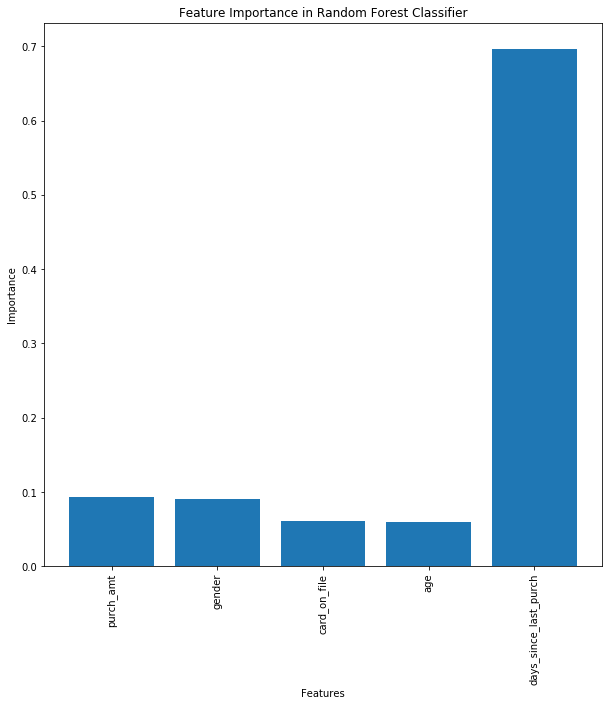

In [32]:
plt.figure(figsize=(10,10))
plt.bar(features.columns[0:30], rfm.feature_importances_[0:30])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [ ]:
Gradient Boosting Classifier

In [33]:
gb_params ={
    'n_estimators': 1500,
    'max_features': 0.9,
    'learning_rate' : 0.25,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

gb = GradientBoostingClassifier(**gb_params)
# Fit the model to our SMOTE train and target
gb.fit(smote_X_train, smote_y_train)
# Get our predictions
gb_predictions = gb.predict(X_test)
print('Accuracy score for Gradient Boosting Classifier:', gb.score(X_test, y_test))
print(classification_report(y_test, gb_predictions))
Confusion_matrix = confusion_matrix(y_test, gb_predictions)
print(Confusion_matrix)

Accuracy score for Gradient Boosting Classifier: 0.8620666666666666
              precision    recall  f1-score   support

       False       0.90      0.94      0.92     25024
        True       0.61      0.45      0.52      4976

    accuracy                           0.86     30000
   macro avg       0.76      0.70      0.72     30000
weighted avg       0.85      0.86      0.85     30000

[[23599  1425]
 [ 2713  2263]]


In [ ]:
Feature ranking via Gradient Boosting classifier

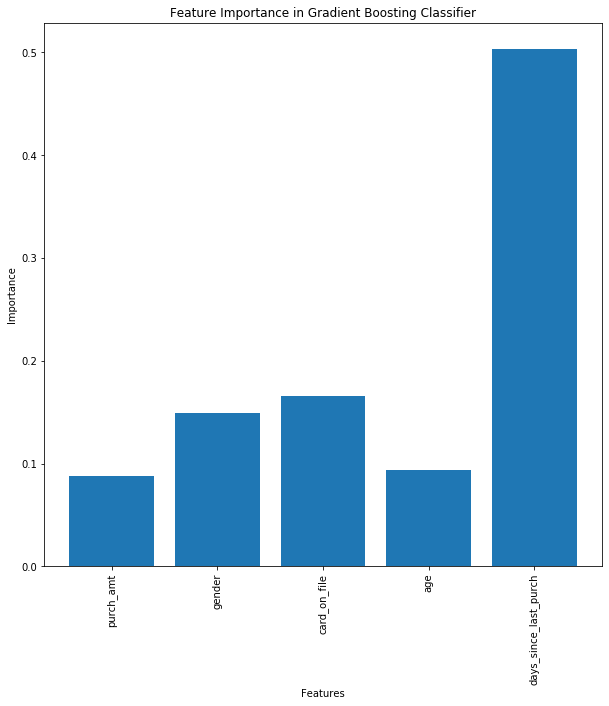

In [34]:
plt.figure(figsize=(10,10))
plt.bar(features.columns[0:30], gb.feature_importances_[0:30])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Gradient Boosting Classifier')
plt.show()

Logistic Regression

In [36]:
#Fitting the model
lr= LogisticRegression()
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)
print('Accuracy Score for Logistic Regression Model:', lr.score(smote_X_train, smote_y_train))
print(classification_report(y_test, lr_pred))
Confusion_matrix = confusion_matrix(y_test, lr_pred)
print(Confusion_matrix)

C:\Users\18644\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score for Logistic Regression Model: 0.5000133376013658
              precision    recall  f1-score   support

       False       1.00      0.00      0.00     25024
        True       0.17      1.00      0.28      4976

    accuracy                           0.17     30000
   macro avg       0.58      0.50      0.14     30000
weighted avg       0.86      0.17      0.05     30000

[[    2 25022]
 [    0  4976]]


In [37]:
from sklearn.linear_model import SGDClassifier

sgd_params = {'alpha': 0.0001,
              'class_weight': None,
              'l1_ratio': 1,
              'loss': 'log',
              'penalty': 'elasticnet',
              'random_state': 1, 
              'shuffle': True}
sgd = SGDClassifier(**sgd_params)
sgd.fit(smote_X_train, smote_y_train)
sgd_pred = sgd.predict(X_test)
print(classification_report(y_test, sgd_pred))
Confusion_matrix = confusion_matrix(y_test, sgd.predict(X_test))
print(Confusion_matrix)

              precision    recall  f1-score   support

       False       0.95      0.83      0.88     25024
        True       0.47      0.76      0.58      4976

    accuracy                           0.82     30000
   macro avg       0.71      0.79      0.73     30000
weighted avg       0.87      0.82      0.83     30000

[[20728  4296]
 [ 1197  3779]]
